In [105]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew #for some statistics

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

from subprocess import check_output


In [106]:
print(check_output(["ls", "../Kaggle-HousesPrice/input"]).decode("utf8")) #check the files available in the directory

test.csv
train.csv



In [107]:
# Load train and test datasets into data frames
train = pd.read_csv('../Kaggle-HousesPrice/input/train.csv')
test = pd.read_csv('../Kaggle-HousesPrice/input/test.csv')

In [108]:
# Display the first 5 rows of the train & test datasets
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [109]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [110]:
# Check the sample size and number of features
print ('The train data shape before dropping Id: {}'.format(train.shape))
print ('The test data shape before dropping Id: {}'.format(test.shape))

The train data shape before dropping Id: (1460, 81)
The test data shape before dropping Id: (1459, 80)


In [111]:
# Take out the Id column before dropping it
train_id = train['Id']
test_id = test['Id']

# Drop
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

In [112]:
# Check the data shapes again:
print ('The train data shape after dropping Id: {}'.format(train.shape))
print ('The test data shape after dropping Id: {}'.format(test.shape))

The train data shape after dropping Id: (1460, 80)
The test data shape after dropping Id: (1459, 79)


###Data Cleaning

Data Description: http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt

#### Outliers detection and manipulation

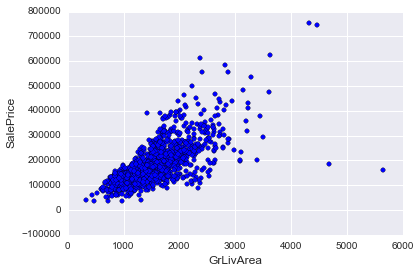

In [113]:
# Scatter plot GrLivArea vs SalePrice
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.xlabel('GrLivArea', fontsize=12)
plt.ylabel('SalePrice', fontsize=12)
plt.show();

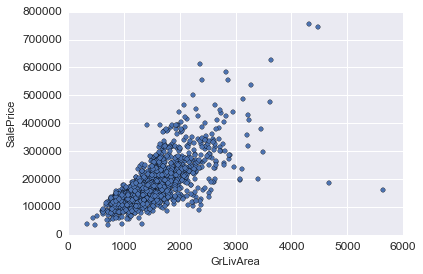

In [114]:
# Other way to do the scatter
data = pd.concat([train['GrLivArea'], train['SalePrice']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0, 800000), fontsize=12);

<i> It can be seen that there are 2 outliers at the bottom right corner.

In [115]:
# Eleminate the outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

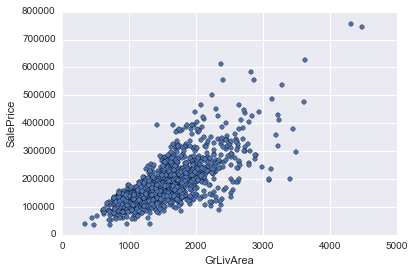

In [116]:
# Re-check the scatter plot
data = pd.concat([train['GrLivArea'], train['SalePrice']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0, 800000));

<i> We are not attempting to remove all the outliers. We are going to make our model robust with them.

### Target Variable: SalePrice

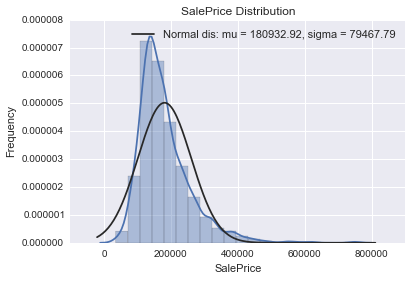

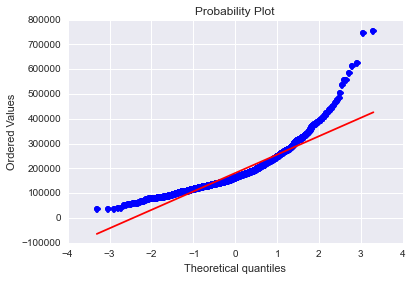

In [117]:
# SalePrice Distribution & Probability Plot
# Get mu and sigma
(mu, sigma) = norm.fit(train['SalePrice'])
#print ('mu = {:.2f} and sigma = {:.2f}').format(mu, sigma)
sns.distplot(train['SalePrice'], fit=norm, bins=20);
plt.legend(['Normal dis: mu = {:.2f}, sigma = {:.2f}'.format(mu, sigma)], loc='best', fontsize=11)
plt.ylabel('Frequency')
plt.title('SalePrice Distribution')

# Get the QQ plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

plt.show();

<i> The target is right skewed.

#### Log transform the target variable

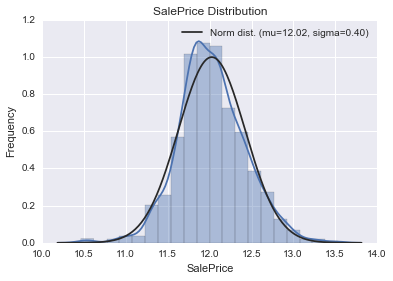

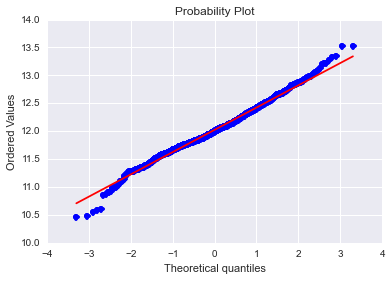

In [118]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train['SalePrice'] = np.log1p(train['SalePrice'])

(mu, sigma) = norm.fit(train['SalePrice'])
sns.distplot(train['SalePrice'], fit=norm, bins=20)
plt.legend(['Norm dist. (mu={:.2f}, sigma={:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice Distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

plt.show();

<i> The data now appear to be more normally distributed.

### Features Engineering

In [119]:
# Combine the training set and test set
n_train = train.shape[0]
n_test = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print('all_data size is: {}'.format(all_data.shape))

all_data size is: (2917, 79)


####Missing data

In [120]:
#Find all variables which have missing values
all_data_na = (all_data.isnull().sum()/len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing %': all_data_na})
missing_data.head(10)

,Missing %
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


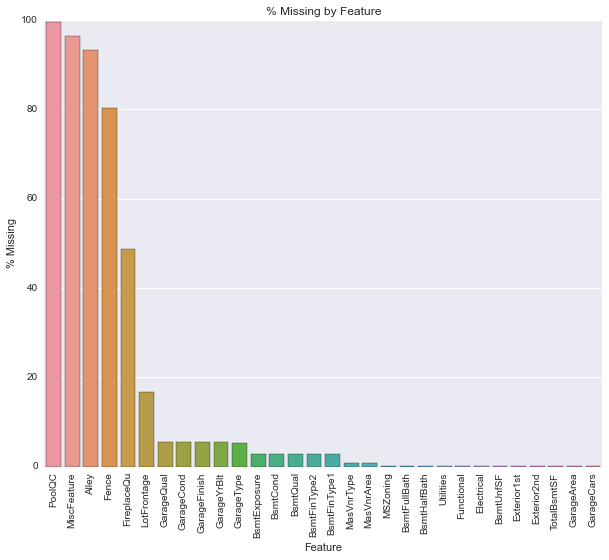

In [121]:
# Plot % missing
f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xticks(rotation='90')
plt.xlabel('Feature')
plt.ylabel('% Missing')
plt.title('% Missing by Feature')
plt.show();

###Data Correlation

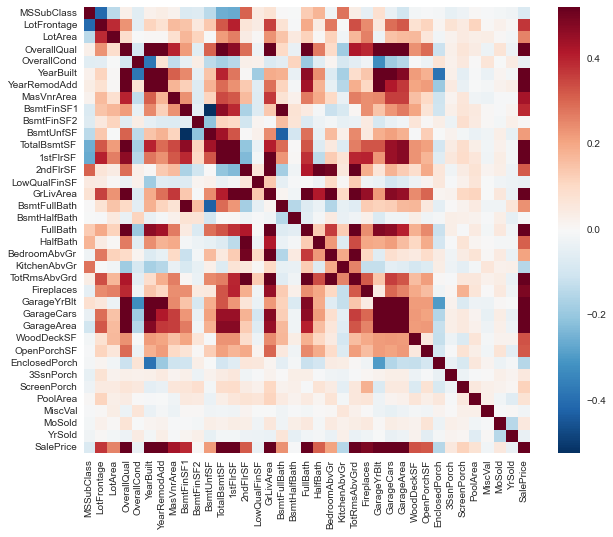

In [122]:
# Correlation Matrix
corr_matrix = train.corr()
plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, vmax=0.1, square=True);

#### Impute missing values

In [123]:
# Pool QC: NA means None (No Pool)
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

In [124]:
# MiscFeature: NA means No Misc Feature
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

In [125]:
# Alley : NA means No Alley 
all_data['Alley'] = all_data['Alley'].fillna('None')

In [126]:
# Fence  : NA means No Fence  
all_data['Fence'] = all_data['Fence'].fillna('None')

In [127]:
# FireplaceQu : NA means No FireplaceQu  
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

In [128]:
# LotFrontage: LotFrontage is likely similar in the same neighborhood --> replace missing by median 
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [129]:
# GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

In [130]:
# GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [131]:
# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : 
# missing values are likely zero for having no basement
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [132]:
#BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : 
#For all these categorical basement-related features, NaN means that there is no basement.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [133]:
#MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. 
#We can fill 0 for the area and None for the type.
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')

In [134]:
#MSZoning (The general zoning classification): we can fill in missing values with the mode
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [135]:
#Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . 
#Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. 
#We can then safely remove it.
all_data = all_data.drop(['Utilities'], axis=1)

In [136]:
#Functional : data description says NA means typical
all_data['Functional'] = all_data['Functional'].fillna('Typ')

In [137]:
#Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [138]:
#KitchenQual: Only one NA value, and same as Electrical, 
#we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [139]:
#Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. 
#We will just substitute in the most common string
#all_data.Exterior1st.value_counts()
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [140]:
#SaleType : Fill in again with most frequent which is "WD"
#all_data['SaleType'].value_counts()
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [141]:
#MSSubClass : Na most likely means No building class. We can replace missing values with None
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [142]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


###More features engeneering
####Transforming some numerical variables that are really categorical

In [143]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

####Label Encoding some categorical variables that may contain information in their ordering set

In [144]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for col in cols:
    le = LabelEncoder()
    le.fit(list(all_data[col].values))
    all_data[col] = le.transform(list(all_data[col].values))
    

In [145]:
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


In [146]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

###Skewed

In [147]:
#Take all numeric features
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

#Check skew of all numeric features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness.head(10)

,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


####Box Cox Transformation of (highly) skewed features

In [148]:
skewness = skewness[abs(skewness)>0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

There are 59 skewed numerical features to Box Cox transform


In [149]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

####Getting dummy categorical features

In [150]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [151]:
# Get back train and test set
train = all_data[:n_train]
test = all_data[n_train:]

### Modeling

In [152]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

#### Use cross-validation function of sckit-lean: cross_val_score. Shuffle the data before validation

In [153]:
# Define a new cross-validation function based on the cross_val_score
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [154]:
# Lasso regression
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

In [155]:
# Elastic Net Regression
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [156]:
# Kernel Ridge Regression
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [157]:
# Gradient Boosting Regression
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [158]:
# XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [159]:
# LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

#### Scoring the base models

In [160]:
score = rmsle_cv(lasso)
print ("\n Lasso score: {:.4f} ({:.4f})".format(score.mean(), score.std()))


 Lasso score: 0.1115 (0.0074)


In [161]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [162]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [163]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1177 (0.0080)



In [164]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1161 (0.0079)



In [165]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1162 (0.0071)



### Stacking model

In [166]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [167]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1091 (0.0075)



In [168]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [169]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1085 (0.0074)


####Ensembling StackedRegressor, XGBoost and LightGBM

In [170]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [171]:
##StackedRegressor:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.0781571937916334


In [172]:
#XGBoost 
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.0785165142425036


In [173]:
#LightGBM:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.07307464036005418


In [174]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.0754109836412043


In [175]:
#Ensemble prediction:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [177]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)